In [1]:
#pip install wfdb

In [2]:
#pip install matplotlib

In [3]:
#pip install torchmetrics

In [4]:
import torch

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [5]:
import pandas as pd
import numpy as np
import wfdb
import ast
import time

# ECG 데이터 로드 함수
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# 데이터 경로 설정
path = './'
sampling_rate=500

# ptbxl_database.csv 파일로부터 진단 정보 로드
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# 원본 신호 데이터 로드
X = load_raw_data(Y, sampling_rate, path)

# scp_statements.csv 파일로부터 진단 정보 집계를 위한 데이터 로드
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

# 진단 정보를 집계하는 함수 정의
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# 진단 정보를 집계하여 대표 클래스로 변환하여 데이터프레임에 추가
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# 데이터를 학습용과 테스트용 으로 분할
#strat_fold = 10인 부분을 테스트 데이터로 사용
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [6]:
from sklearn.model_selection import train_test_split

# train data 중 25%를 validation data로 활용
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

#레이블을 원-핫 인코딩 형식으로 변환
mlb = MultiLabelBinarizer()
y_train_encoded = mlb.fit_transform(y_train)
y_val_encoded = mlb.fit_transform(y_val)
y_test_encoded = mlb.transform(y_test)

print(y_train_encoded.shape)
print(y_val_encoded.shape)
print(y_test_encoded.shape)

# 모델에 input 하기 위해 permute
X_train_permuted = X_train.transpose(0, 2, 1)
X_val_permuted = X_val.transpose(0, 2, 1)
X_test_permuted = X_test.transpose(0, 2, 1)

print(X_train_permuted.shape)
print(X_val_permuted.shape)
print(X_test_permuted.shape)

(14725, 5000, 12)
(4909, 5000, 12)
(2203, 5000, 12)
(14725,)
(4909,)
(2203,)
(14725, 5)
(4909, 5)
(2203, 5)
(14725, 12, 5000)
(4909, 12, 5000)
(2203, 12, 5000)


In [8]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [9]:
class IdentityShortcut(nn.Module):
    """
        A class to make Identity Mapping Shortcut

        Attributes:
            pooling : A max pooling layer
            extra_cahnnel : The difference between input an output channels
    """
    def __init__(self, in_channels, out_channels, stride):
        """
            Initialize the Identity Shortcut Class

            Args:
                in_channels: number of input channels
                out_channels: number of output channels
                stride: size of stride

            Returns:
                None
        """
        super().__init__()
        self.pooling = nn.MaxPool1d(1, stride=stride)
        self.extra_channel = out_channels - in_channels

    def forward(self, x):
        x = F.pad(x, (0, 0, 0, self.extra_channel))
        x = self.pooling(x)
        return x

class ResidualBlock(nn.Module):
    """
        A class about residual block

        When stride == 1, just add input value to output of residual block
        When stride == 2, process the input value according to shortcut type and add it to output of residual block
        Attributes:
            residual_blcok: A sequential container to sequentially configure the layers for residual learning
            shortcut: A shortcut connection of residual block
            relu: A relu activation layer
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, shortcut_type=None, dropout_prob=0.2):
        """
            Initialize the residual block

            Args:
                in_channels: The number of input channels
                out_channels: The number of output channels
                kernel_size: The number of kernnel size in the convolution layers
                stride: The size of stride
                shortcut_type: The type of shortcut connection when stride is not 1
            Returns:
                None
        """
        super().__init__()
        self.residual_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout_prob),  # dropout 레이어 추가
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=1, bias=False),
            nn.BatchNorm1d(out_channels),
        )

        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()

        if stride != 1:
            if shortcut_type == 'A':
                self.shortcut = IdentityShortcut(in_channels, out_channels, stride)
            elif shortcut_type == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, stride),
                    nn.BatchNorm2d(out_channels)
                )


    def forward(self, x):
        x = self.residual_block(x) + self.shortcut(x)
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    """
        A class about residual network

        Attributes:
            conv1_x: First set of layers
            conv2_x: Second set of residual blocks
            conv3_x: Third set of residual blocks
            conv4_x: Fourth set of residual blocks
            avg_pool: A average pooling layer of residual network
            flatten: A flatten layer for the fully connected layer
            fc: A fully connected layer to get probability of each class about given image
    """
    def __init__(self, conv_num, num_classes, dropout_prob=0.2):
        """
            Initialize the residual network

            Args:
                conv_num: The number of residual blocks in each set of residual block
                num_classes: The number of classes to predict
            Returns:
                None
        """
        super().__init__()
        self.conv1_x = nn.Sequential(
            nn.Conv1d(12, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )

        self.conv2_x = nn.Sequential(*[ResidualBlock(16, 16, 3, 1) for _ in range(conv_num[0])])
        self.conv3_x = nn.Sequential(ResidualBlock(16, 32, 3, 2, 'A'), *[ResidualBlock(32, 32, 3, 1) for _ in range(conv_num[1] - 1)])
        self.conv4_x = nn.Sequential(ResidualBlock(32, 64, 3, 2, 'A'), *[ResidualBlock(64, 64, 3, 1) for _ in range(conv_num[2] - 1)])
        self.conv5_x = nn.Sequential(ResidualBlock(64, 128, 3, 2, 'A'), *[ResidualBlock(128, 128, 3, 1) for _ in range(conv_num[3] - 1)])

        #self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.avg_pool = nn.AvgPool1d(64, stride=64)
        self.flatten = nn.Flatten()


        self.fc = nn.Linear(in_features=1152, out_features=num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.conv1_x(x)
        #print("After conv1_x:", x.shape)
        x = self.conv2_x(x)
        #print("After conv2_x:", x.shape)
        x = self.conv3_x(x)
        #print("After conv3_x:", x.shape)
        x = self.conv4_x(x)
        #print("After conv4_x:", x.shape)
        x = self.conv5_x(x)
        #print("After conv5_x:", x.shape)
        x = self.avg_pool(x)

        # 입력 데이터 차원을 conv 레이어의 입력 크기에 맞게
        x = x.view(x.size(0), x.size(1) * x.size(2))

        # 변환된 입력 데이터의 shape 출력
        #print("Reshaped Input shape:", x.shape)

        x = self.fc(x)
        return x

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from torchmetrics import Accuracy
from sklearn.metrics import roc_auc_score  # 추가된 부분
import matplotlib.pyplot as plt

# 데이터 전처리 및 모델 정의 코드

# 데이터셋에서 특성의 크기와 클래스 개수 가져오기
input_features = X_train_permuted.shape[2]  # 입력 특성의 크기
num_classes = y_train_encoded.shape[1]  # 클래스 개수

# 하이퍼파라미터 설정
learning_rate = 0.001
batch_size = 128
epochs = 50

# 모델에 입력할 수 있는 shape으로 데이터 reshape
X_train_reshaped = torch.tensor(X_train_permuted, dtype=torch.float32)
X_val_reshaped = torch.tensor(X_val_permuted, dtype=torch.float32)
X_test_reshaped = torch.tensor(X_test_permuted, dtype=torch.float32)

# 레이블 데이터도 torch tensor로 변환
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32)

# 데이터 로더 생성
train_dataset = torch.utils.data.TensorDataset(X_train_reshaped, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_reshaped, y_val_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(X_test_reshaped, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 초기화 및 옵티마이저 설정(ResNet101)
# ResNet152 : [3, 8, 36, 3]
model = ResNet([3, 4, 23, 3], num_classes, dropout_prob=0.2).to('cuda')
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Train accuracy 계산
            train_preds = torch.sigmoid(outputs).round()
            train_correct += (train_preds == labels).sum().item()
            train_total += labels.numel()
            train_loss += loss.item()

        train_accuracy = train_correct / train_total

        # Validation loss 계산
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to('cuda'), val_labels.to('cuda')
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

                # Validation accuracy 계산
                val_preds = torch.sigmoid(val_outputs).round()
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.numel()

        val_accuracy = val_correct / val_total
        val_loss /= len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # 학습 완료 후 테스트 데이터로 평가
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to('cuda'), test_labels.to('cuda')
            test_outputs = model(test_inputs)
            test_loss += criterion(test_outputs, test_labels).item()

            # Test accuracy 계산
            test_preds = torch.sigmoid(test_outputs).round()
            test_correct += (test_preds == test_labels).sum().item()
            test_total += test_labels.numel()

    test_accuracy = test_correct / test_total
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 모델 학습
start_time = time.time()
train_model(model, criterion, optimizer, epochs)
end_time = time.time()
execution_time = end_time - start_time
print(f"It took {execution_time} seconds to run")

Epoch [1/50], Train Loss: 48.8653, Train Accuracy: 0.8113, Validation Loss: 0.4305, Validation Accuracy: 0.8025
Epoch [2/50], Train Loss: 41.7664, Train Accuracy: 0.8452, Validation Loss: 0.3582, Validation Accuracy: 0.8484
Epoch [3/50], Train Loss: 39.4822, Train Accuracy: 0.8570, Validation Loss: 0.3320, Validation Accuracy: 0.8630
Epoch [4/50], Train Loss: 37.5207, Train Accuracy: 0.8659, Validation Loss: 0.3211, Validation Accuracy: 0.8644
Epoch [5/50], Train Loss: 37.1810, Train Accuracy: 0.8668, Validation Loss: 0.3501, Validation Accuracy: 0.8483
Epoch [6/50], Train Loss: 35.7009, Train Accuracy: 0.8724, Validation Loss: 0.2956, Validation Accuracy: 0.8786
Epoch [7/50], Train Loss: 35.0279, Train Accuracy: 0.8755, Validation Loss: 0.3019, Validation Accuracy: 0.8762
Epoch [8/50], Train Loss: 34.6807, Train Accuracy: 0.8774, Validation Loss: 0.3101, Validation Accuracy: 0.8765
Epoch [9/50], Train Loss: 34.0114, Train Accuracy: 0.8794, Validation Loss: 0.3061, Validation Accuracy:

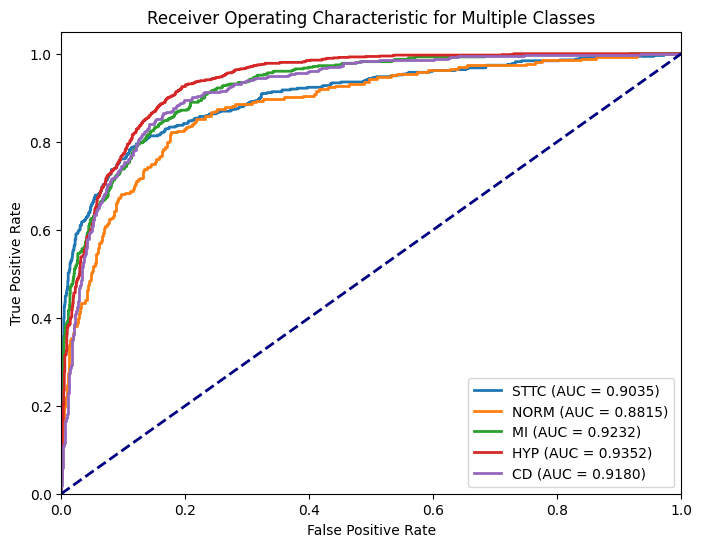

Graphs plotted.


In [12]:
# 클래스 이름 가져오기 함수 정의
def get_diagnostic_class(class_index):
    class_names = ['STTC', 'NORM', 'MI', 'HYP', 'CD']
    return class_names[class_index]

# 각 클래스별 ROC AUC 평가 함수
def calculate_roc_auc(outputs, targets):
    roc_auc_scores = []
    fpr_list = []
    tpr_list = []
    for i in range(outputs.shape[1]):
        roc_auc = roc_auc_score(targets[:, i], outputs[:, i])
        fpr, tpr, _ = roc_curve(targets[:, i], outputs[:, i])
        roc_auc_scores.append(roc_auc)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
    return roc_auc_scores, fpr_list, tpr_list

# 평가 함수를 수정하여 클래스별 ROC AUC 및 곡선 데이터를 반환하도록 변경
def evaluate_model(model, dataloader):
    model.eval()
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            all_outputs.append(torch.sigmoid(outputs).cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    roc_auc_scores, fpr_list, tpr_list = calculate_roc_auc(all_outputs, all_targets)
    return roc_auc_scores, fpr_list, tpr_list

# 모델 평가 및 클래스별 ROC AUC 및 곡선 데이터 출력
test_roc_auc_scores, fpr_list, tpr_list = evaluate_model(model, test_loader)

# 그래프 생성
plt.figure(figsize=(8, 6))
for i, (fpr, tpr, roc_auc) in enumerate(zip(fpr_list, tpr_list, test_roc_auc_scores)):
    class_name = get_diagnostic_class(i)  # 클래스 이름 가져오기
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.4f})')

# 그래프 설정
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiple Classes')
plt.legend(loc="lower right")
plt.show()

print("Graphs plotted.")
